In [8]:
#link the src folder
import sys
sys.path.append('..')
import src

## Import Packages and modules

In [9]:
#load packages and functions from module
from src.preprocessing import load_data
from src.preprocessing import split_train_test_data
from src.preprocessing import check_outliers
from src.preprocessing import build_preprocessing_pipeline
from src.dec_tree import train_decision_tree_pipeline
from src.randomForest import train_random_forest_pipeline
from src.svr import train_svr_model_pipeline
from src.lin_regress import train_linear_model_pipeline
from src.xgb_model import train_xgb_model_pipeline
from src.feat_eng import apply_feature_engineering
from src.gridSearch import run_grid_search
from src.PCA_vis import visualize_pca_with_preprocessing
from src.regression_eval import evaluate_regression

In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint
import itertools
import shap
from sklearn.metrics import r2_score

## Getting data and set up

In [11]:
#load file
X, y = load_data("full_data.csv", "q (crosslink density)")
#drop columns that are not needed
columns_to_drop = ["Temperature (°C)","R (J/K*mol)", "Average density of polymer (g/m^3)", "Mw", "Tan(delta)", "Loss modulus (MPa)", "Sample Number", "Storage modulus (MPa)", "Mc (g/mol)", "Formulation"]
X = X.drop(columns=columns_to_drop)
#convert the polymerization to string type
X['Polymerization'] = X['Polymerization'].astype(str)

#get train and test split
X_train, X_test, y_train, y_test = split_train_test_data(X,y)


#split the data into categorical and numerical for both test and train
categorical_columns = ["Polymerization"]
numerical_columns = ["Temp (K)", "per_crosslinker", "dyn_crosslinker", "comonomer"]

In [12]:
#remove outliers from X_train before training
X_train = check_outliers(X_train, numerical_columns)
#look at X_train to make the correct features are left and the rest are dropped
X_train.head()

,per_crosslinker,dyn_crosslinker,comonomer,Polymerization,Temp (K)
7495,0.5,0.5,99,365,347.34
15391,1.0,1.0,98,254,343.95
10152,5.0,5.0,90,365,366.59
14608,1.0,1.0,98,254,304.76
6428,0.5,0.5,99,365,339.67


## Train initial models

These are the initial models that were trained with cross validation of 5.

In [13]:
#train the decision tree
dec_tree = train_decision_tree_pipeline(X_train, y_train, categorical_columns, numerical_columns, cv=5)

Decision Tree Cross-Validation Scores:
  R²:  0.8941 ± 0.0061
  RMSE: 0.0275 ± 0.0011
  MAE: 0.0102 ± 0.0004


In [14]:
#random forest
randomForest = train_random_forest_pipeline(X_train, y_train, categorical_columns, numerical_columns, cv=5)

Random Forest Cross-Validation Scores:
  R²:  0.9149 ± 0.0057
  RMSE: 0.0247 ± 0.0013
  MAE: 0.0103 ± 0.0004


In [15]:
#train the svr model
svr = train_svr_model_pipeline(X_train, y_train, categorical_columns, numerical_columns, cv=5)

SVR Cross-Validation Scores:
  R²:   0.1387 ± 0.0252
  RMSE:  0.0785 ± 0.0004
  MAE:  0.0745 ± 0.0008


In [16]:
#train the linear regression
linReg = train_linear_model_pipeline(X_train, y_train, categorical_columns, numerical_columns, cv = 5)

Linear Regression Cross-Validation Scores:
  R^2:  0.9287 ± 0.0060
  RMSE:  0.0226 ± 0.0013
  MAE:  0.0121 ± 0.0004


In [17]:
#train the xgboost
xgboost = train_xgb_model_pipeline(X_train, y_train, categorical_columns, numerical_columns, cv=5)

XGBoost Cross-Validation Scores:
  R²:   0.9255 ± 0.0056
  RMSE:  0.0231 ± 0.0012
  MAE:  0.0105 ± 0.0003


## Feature Engineering

Apply feature engineering to see how the model performance changes. The new features are conversion to percentage and adding a new column of the crosslink ratio.

In [18]:
#apply feature engineering to the X_train dataset
X_feat = apply_feature_engineering(X_train)

In [19]:
#verify the function to apply feature engineering worked
X_feat.head()

,per_crosslinker,dyn_crosslinker,comonomer,Polymerization,Temp (K),dyn_crosslinker_pct,per_crosslinker_pct,comonomer_pct,crosslink_ratio
7495,0.5,0.5,99.0,365,347.34,0.005,0.005,0.99,0.99980
15391,1.0,1.0,98.0,254,343.95,0.010,0.010,0.98,0.99990
10152,5.0,5.0,90.0,365,366.59,0.050,0.050,0.90,0.99998
14608,1.0,1.0,98.0,254,304.76,0.010,0.010,0.98,0.99990
6428,0.5,0.5,99.0,365,339.67,0.005,0.005,0.99,0.99980


In [20]:
#drop columns and verify
columns_to_drop = ["per_crosslinker","dyn_crosslinker", "comonomer"]
X_feat_train = X_feat.drop(columns=columns_to_drop)
X_feat_train.head()

,Polymerization,Temp (K),dyn_crosslinker_pct,per_crosslinker_pct,comonomer_pct,crosslink_ratio
7495,365,347.34,0.005,0.005,0.99,0.99980
15391,254,343.95,0.010,0.010,0.98,0.99990
10152,365,366.59,0.050,0.050,0.90,0.99998
14608,254,304.76,0.010,0.010,0.98,0.99990
6428,365,339.67,0.005,0.005,0.99,0.99980


In [21]:
#description of the new dataset
X_feat_train.describe()

,Temp (K),dyn_crosslinker_pct,per_crosslinker_pct,comonomer_pct,crosslink_ratio
count,17885.000000,17885.000000,17885.000000,17885.000000,17885.000000
mean,333.599171,0.056200,0.020060,0.923741,4.033326
std,23.309222,0.046533,0.019095,0.060279,3.339746
min,293.000000,0.005000,0.005000,0.800000,0.999800
25%,313.420000,0.010000,0.005000,0.900000,0.999900
50%,333.610000,0.045000,0.010000,0.950000,2.999940
75%,353.850000,0.090000,0.050000,0.980000,8.998200
max,373.650000,0.150000,0.050000,0.990000,8.999100


In [22]:
#separate categorical and numerical columns
categorical_columns_ft = ["Polymerization"]
numerical_columns_ft = ["Temp (K)", "per_crosslinker_pct", "dyn_crosslinker_pct", "comonomer_pct", "crosslink_ratio"]

In [23]:
#train random forest
randomForest_ft = train_random_forest_pipeline(X_feat_train, y_train, categorical_columns_ft, numerical_columns_ft, cv=5)

Random Forest Cross-Validation Scores:
  R²:  0.9149 ± 0.0057
  RMSE: 0.0247 ± 0.0013
  MAE: 0.0103 ± 0.0004


In [24]:
#train linear regression with the new dataset
linReg_ft = train_linear_model_pipeline(X_feat_train, y_train, categorical_columns_ft, numerical_columns_ft, cv = 5)

Linear Regression Cross-Validation Scores:
  R^2:  0.9296 ± 0.0059
  RMSE:  0.0224 ± 0.0013
  MAE:  0.0123 ± 0.0004


In [25]:
#train the decision tree
dec_tree_ft = train_decision_tree_pipeline(X_feat_train, y_train, categorical_columns_ft, numerical_columns_ft, cv=5)

Decision Tree Cross-Validation Scores:
  R²:  0.8941 ± 0.0061
  RMSE: 0.0275 ± 0.0011
  MAE: 0.0102 ± 0.0004


In [26]:
#train the svr model
svr_ft = train_svr_model_pipeline(X_feat_train, y_train, categorical_columns_ft, numerical_columns_ft, cv=5)

SVR Cross-Validation Scores:
  R²:   0.1301 ± 0.0276
  RMSE:  0.0788 ± 0.0002
  MAE:  0.0748 ± 0.0005


In [27]:
#train the xgboost
xgboost_ft = train_xgb_model_pipeline(X_feat_train, y_train, categorical_columns_ft, numerical_columns_ft, cv=5)

XGBoost Cross-Validation Scores:
  R²:   0.9252 ± 0.0058
  RMSE:  0.0231 ± 0.0013
  MAE:  0.0105 ± 0.0003


## Hyperparameter tuning

Hyperparameter tuning with the feature engineered dataset. Even though those models perform slightly worse the addition of feature can provide some insight into the dataset. Adding the ratio column can help give insight if there is an influence on the results.

In [28]:
#dictionary of the parameters in random forest
rf_params = {
    'regressor__n_estimators': [50, 100, 150, 200, 250, 300], #list of n_estimators
    'regressor__max_depth': [5,10], #list of max depth
    'regressor__min_samples_leaf': [1,3,5] #list of min_samples_leaf picked on random
}

#run the function to the parameters
RF_parameters = run_grid_search(X_feat_train, y_train, RandomForestRegressor(), rf_params, categorical_columns_ft, numerical_columns_ft, cv=5, scoring='r2')

Best parameters: {'regressor__max_depth': 5, 'regressor__min_samples_leaf': 5, 'regressor__n_estimators': 150}
Best r2 score: 0.9361


In [29]:
#dictionary of the parameters in linear regression
lr_params = {
    'regressor__fit_intercept': [True, False], #fit intercept true or false are the possible outcomes to include intercept or not
    'regressor__n_jobs' : [-1, 1], #n_jobs 
}

#get the best parameters
LR_parameters = run_grid_search( X_feat_train, y_train, LinearRegression(), lr_params, categorical_columns_ft, numerical_columns_ft, cv=5, scoring='r2')

Best parameters: {'regressor__fit_intercept': True, 'regressor__n_jobs': -1}
Best r2 score: 0.9296


In [30]:
#dictionary of the parameters for decision tree
dec_tree_params = {
    'regressor__criterion': ['squared_error', 'friedman_mse', 'absolute_error'], #list of criterion
    'regressor__splitter': ['best', 'random'], #splitter possibilities
    'regressor__min_samples_leaf' : [1, 2, 3, 4], #minimum sample leaf list
    'regressor__max_depth' : [5,10] #max depth
}

#get the parameters for the decision tree
DT_parameters = run_grid_search(X_feat_train, y_train, DecisionTreeRegressor(), dec_tree_params, categorical_columns_ft, numerical_columns_ft, cv=5, scoring='r2')

Best parameters: {'regressor__criterion': 'friedman_mse', 'regressor__max_depth': 5, 'regressor__min_samples_leaf': 4, 'regressor__splitter': 'random'}
Best r2 score: 0.9365


In [31]:
#dictionary of the parameters
svr_params = {
    'regressor__kernel': ['rbf', 'linear', 'poly', 'sigmoid'], #kernel for the model
    'regressor__C': [1, 2], 
    'regressor__epsilon': [0.01, 0.1],
}

#get the parameters for svr
svr_parameters = run_grid_search(X_feat_train, y_train, SVR(), svr_params, categorical_columns_ft, numerical_columns_ft, cv=5, scoring='r2')

Best parameters: {'regressor__C': 1, 'regressor__epsilon': 0.01, 'regressor__kernel': 'linear'}
Best r2 score: 0.9263


In [32]:
#dictionary of the parameters
xg_params = {
    'regressor__n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500], #possible n_estimators
    'regressor__learning_rate': [0.01, 0.1], #learning rate as it iterates
    'regressor__max_depth': [5, 10, 15], #max depth
}

#get parameters for xgboost
xg_parameters = run_grid_search(X_feat_train, y_train, XGBRegressor(), xg_params, categorical_columns_ft, numerical_columns_ft, cv=5, scoring='r2')

Best parameters: {'regressor__learning_rate': 0.01, 'regressor__max_depth': 5, 'regressor__n_estimators': 450}
Best r2 score: 0.9349


## Visualizations with PCA

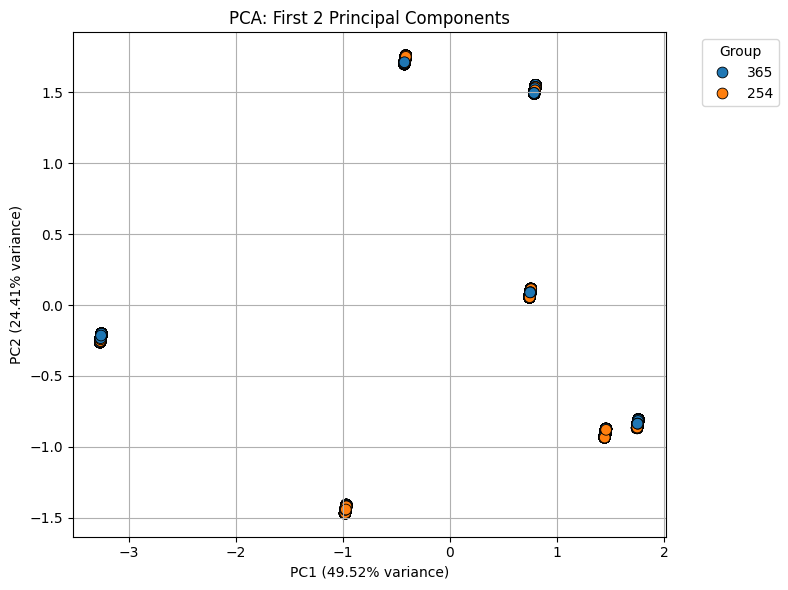

In [33]:
#visualize with PCA based on the polymerization group
pca = visualize_pca_with_preprocessing(X_feat_train, #dataset
                                       categorical_columns=categorical_columns_ft, #the new categorical columns
                                       numerical_columns=numerical_columns_ft, #the new numerical columns
                                       n_components=2, #number of components
                                       color_by=X_feat_train['Polymerization'] #based on the polymerization
                                      )

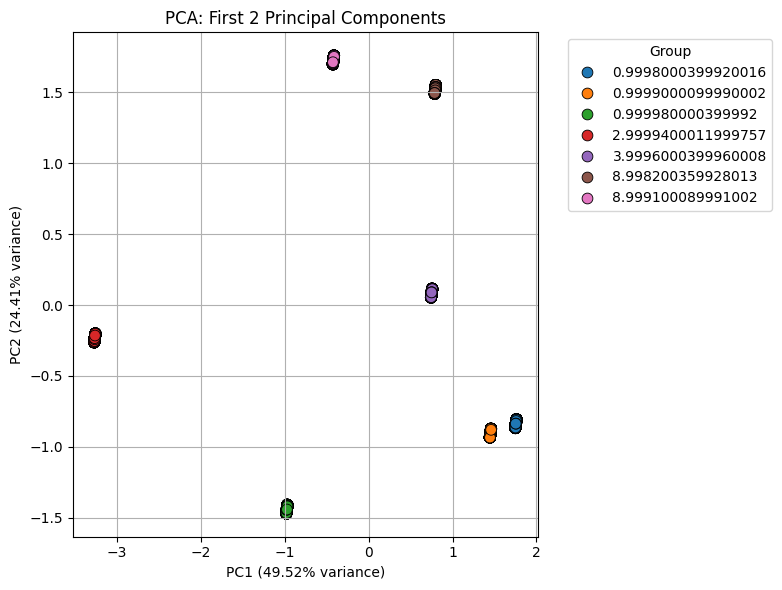

In [34]:
#visualize with PCA based on the crosslink ratio
pca = visualize_pca_with_preprocessing(X_feat_train, #dataset 
                                       categorical_columns=categorical_columns_ft, #categorical data
                                       numerical_columns=numerical_columns_ft, #numerical data
                                       n_components=2, #number of components
                                       color_by=X_feat_train['crosslink_ratio'] #the grouping
                                      )

## Evaluate Models

In [35]:
#apply feature engineering to the test dataset for evaluation
X_test = apply_feature_engineering(X_test)
#drop the columns from the test set
columns_to_drop = ["per_crosslinker","dyn_crosslinker", "comonomer"]
X_feat_test = X_test.drop(columns=columns_to_drop)
#verify
X_feat_test.head()

,Polymerization,Temp (K),dyn_crosslinker_pct,per_crosslinker_pct,comonomer_pct,crosslink_ratio
1765,365,306.01,0.045,0.005,0.95,8.99820
2323,365,310.05,0.150,0.050,0.80,2.99994
18754,254,351.94,0.090,0.010,0.90,8.99910
11952,254,333.36,0.005,0.005,0.99,0.99980
1311,365,302.72,0.050,0.050,0.90,0.99998


In [36]:
#verify the train and test datasets match
X_feat_train.head()

,Polymerization,Temp (K),dyn_crosslinker_pct,per_crosslinker_pct,comonomer_pct,crosslink_ratio
7495,365,347.34,0.005,0.005,0.99,0.99980
15391,254,343.95,0.010,0.010,0.98,0.99990
10152,365,366.59,0.050,0.050,0.90,0.99998
14608,254,304.76,0.010,0.010,0.98,0.99990
6428,365,339.67,0.005,0.005,0.99,0.99980


In [37]:
#preprocess the data
preprocessor = build_preprocessing_pipeline(categorical_columns_ft, numerical_columns_ft)
#preprocess the datasets, train is fitted
X_train_processed = preprocessor.fit_transform(X_feat_train)
X_test_processed = preprocessor.transform(X_feat_test)

 Evaluation Metrics for Random Forest:
  R²   : 0.9417
  RMSE : 0.0206
  MAE  : 0.0100


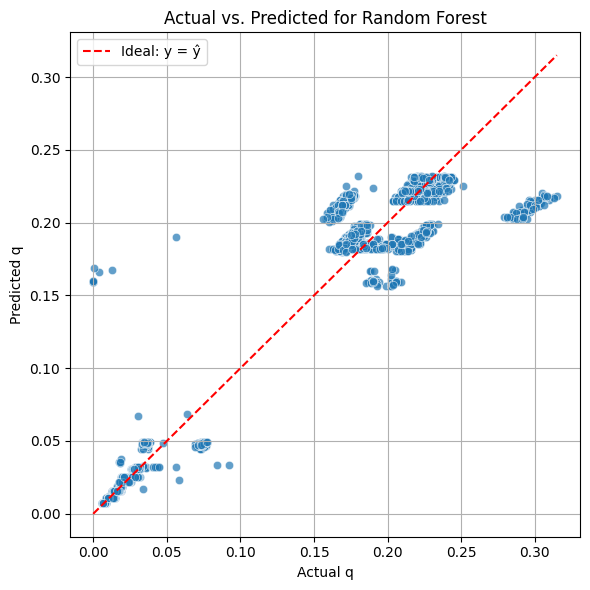

In [38]:
# Best params for rf: {'model__max_depth': 5, 'model__min_samples_leaf': 5, 'model__n_estimators': 250}
#get the model
model = RandomForestRegressor(max_depth=5,min_samples_leaf=5, n_estimators=250)
#fit the model
rf_model = model.fit(X_train_processed, y_train)
#predict with test dataset
y_pred_rf = rf_model.predict(X_test_processed)
#get the scores for this model
rf_eval = evaluate_regression(y_test, y_pred_rf, model_name="Random Forest")

#plot actual vs predicted 
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.7) #define x and y
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal: y = ŷ')#plot x and y within the range of min and max
plt.xlabel("Actual q") #x axis label
plt.ylabel("Predicted q") #y axis label
plt.title("Actual vs. Predicted for Random Forest") #title of plot
plt.legend() #legen
plt.grid(True) #turn on grid
plt.tight_layout()
plt.show()

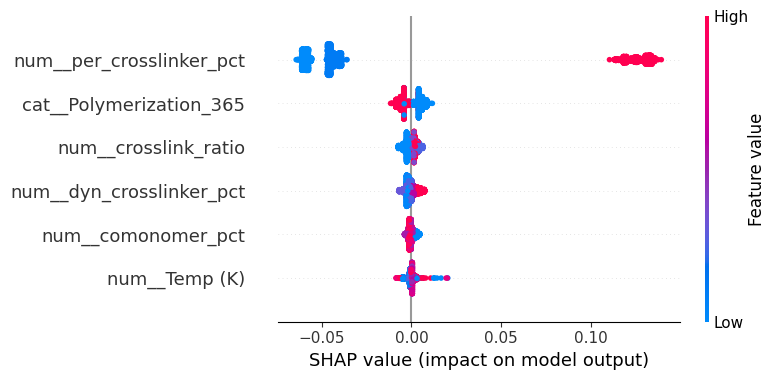

In [39]:
#SHAP values for random forest model
#get feature names
feature_names = preprocessor.get_feature_names_out()
#convert test dataset to a dataframe
X_test_df = pd.DataFrame(X_test_processed, columns=feature_names)
#explainer to random forest which in this case is defined as model
explainer = shap.Explainer(model)
#get the shap values
shap_values = explainer.shap_values(X_test_processed)
#plot the SHAP values
shap.summary_plot(shap_values, X_test_df)

 Evaluation Metrics for Linear Regression:
  R²   : 0.9350
  RMSE : 0.0217
  MAE  : 0.0123


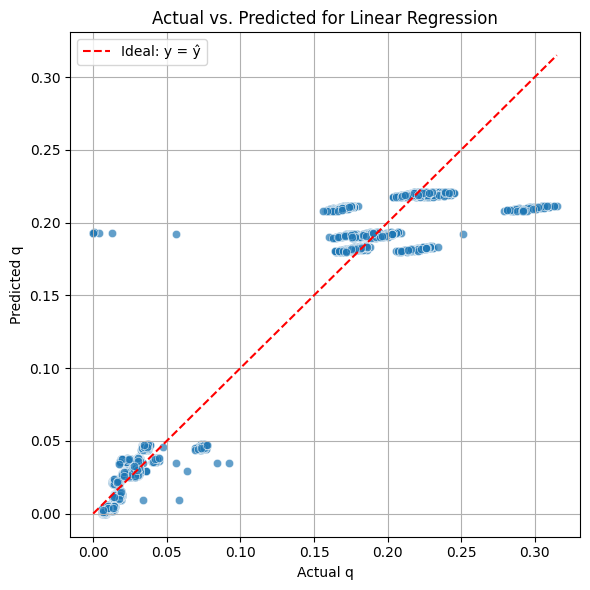

In [40]:
#Best params for lr: {'model__fit_intercept': True, 'model__n_jobs': -1}
#evaluate linear model
model_lr = LinearRegression(fit_intercept=True, n_jobs=-1)
lr_model = model_lr.fit(X_train_processed, y_train)
y_pred_lr = lr_model.predict(X_test_processed)
lr_eval = evaluate_regression(y_test, y_pred_lr, model_name="Linear Regression")

#plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred_lr, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal: y = ŷ')
plt.xlabel("Actual q")
plt.ylabel("Predicted q")
plt.title("Actual vs. Predicted for Linear Regression")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

 Evaluation Metrics for Decision Tree:
  R²   : 0.9415
  RMSE : 0.0206
  MAE  : 0.0100


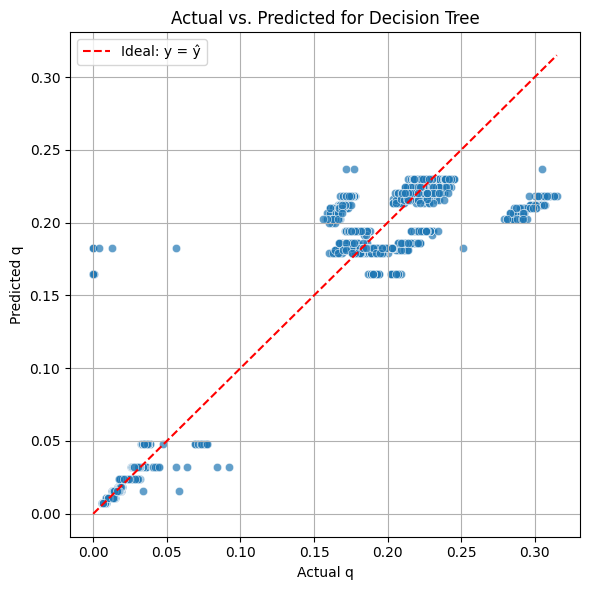

In [41]:
#Best parameters: {'regressor__criterion': 'friedman_mse', 'regressor__max_depth': 5, 'regressor__min_samples_leaf': 1, 'regressor__splitter': 'random'}
#evaluate decision tree
model_dec = DecisionTreeRegressor(criterion='friedman_mse', max_depth=5, min_samples_leaf=1, splitter='random')
dec_model = model_dec.fit(X_train_processed, y_train)
y_pred_dec = dec_model.predict(X_test_processed)
dec_eval = evaluate_regression(y_test, y_pred_dec, model_name="Decision Tree")

#plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred_dec, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal: y = ŷ')
plt.xlabel("Actual q")
plt.ylabel("Predicted q")
plt.title("Actual vs. Predicted for Decision Tree")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

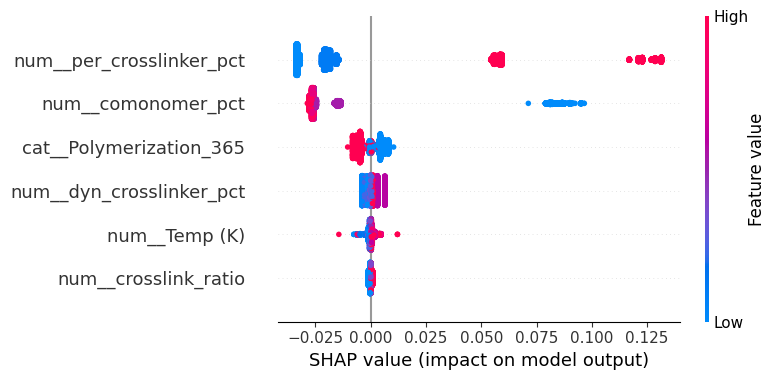

In [42]:
#SHAP values for decision tree model

feature_names = preprocessor.get_feature_names_out()
X_test_df = pd.DataFrame(X_test_processed, columns=feature_names)
#here the model is the decision tree
explainer = shap.Explainer(model_dec)
shap_values = explainer.shap_values(X_test_processed)
shap.summary_plot(shap_values, X_test_df)

 Evaluation Metrics for SVR:
  R²   : 0.9314
  RMSE : 0.0223
  MAE  : 0.0119


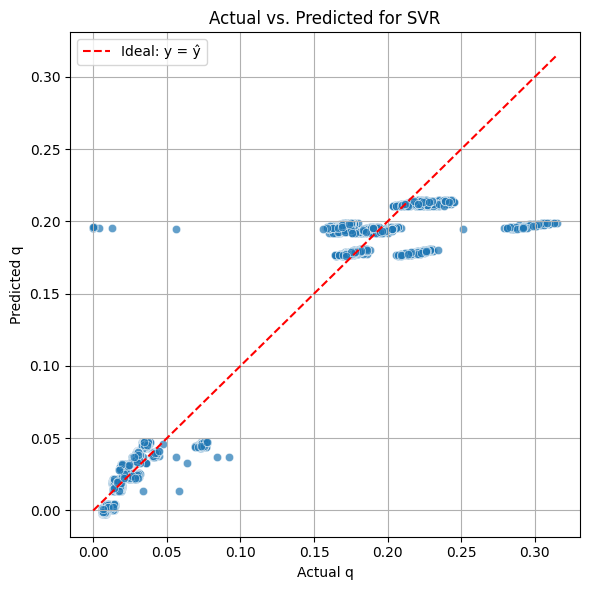

In [43]:
#Best params for regressor_svr: {'model__C': 2, 'model__epsilon': 0.01, 'model__kernel': 'linear'}
#evaluate the svr model
model_svr = SVR(C=1, epsilon=0.01, kernel='linear')
svr_model = model_svr.fit(X_train_processed, y_train)
y_pred_svr = svr_model.predict(X_test_processed)
svr_eval = evaluate_regression(y_test, y_pred_svr, model_name="SVR")

#plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred_svr, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal: y = ŷ')
plt.xlabel("Actual q")
plt.ylabel("Predicted q")
plt.title("Actual vs. Predicted for SVR")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

 Evaluation Metrics for XGBoost:
  R²   : 0.9410
  RMSE : 0.0207
  MAE  : 0.0099


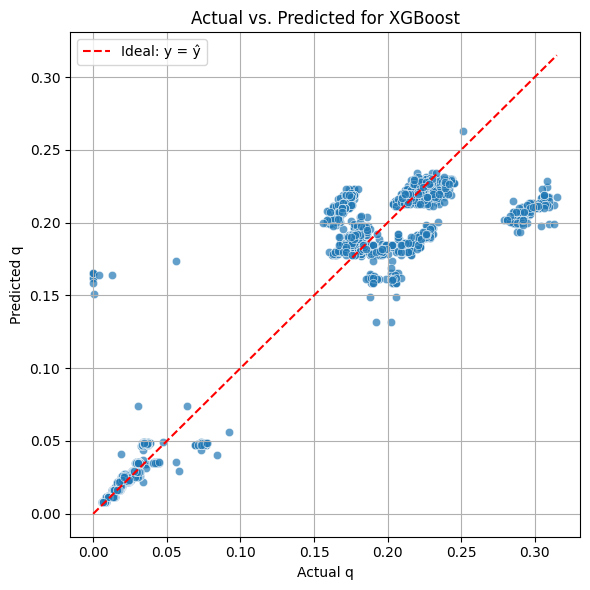

In [44]:
#Best params for regressor_xgb: {'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__n_estimators': 450}
#evaluate the xgb
model_xgb = XGBRegressor(learning_rate=0.01, max_depth=5, n_estimators=450)
xgb_model = model_xgb.fit(X_train_processed, y_train)
y_pred_xgb = xgb_model.predict(X_test_processed)
xgb_eval = evaluate_regression(y_test, y_pred_xgb, model_name="XGBoost")

#plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred_xgb, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal: y = ŷ')
plt.xlabel("Actual q")
plt.ylabel("Predicted q")
plt.title("Actual vs. Predicted for XGBoost")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

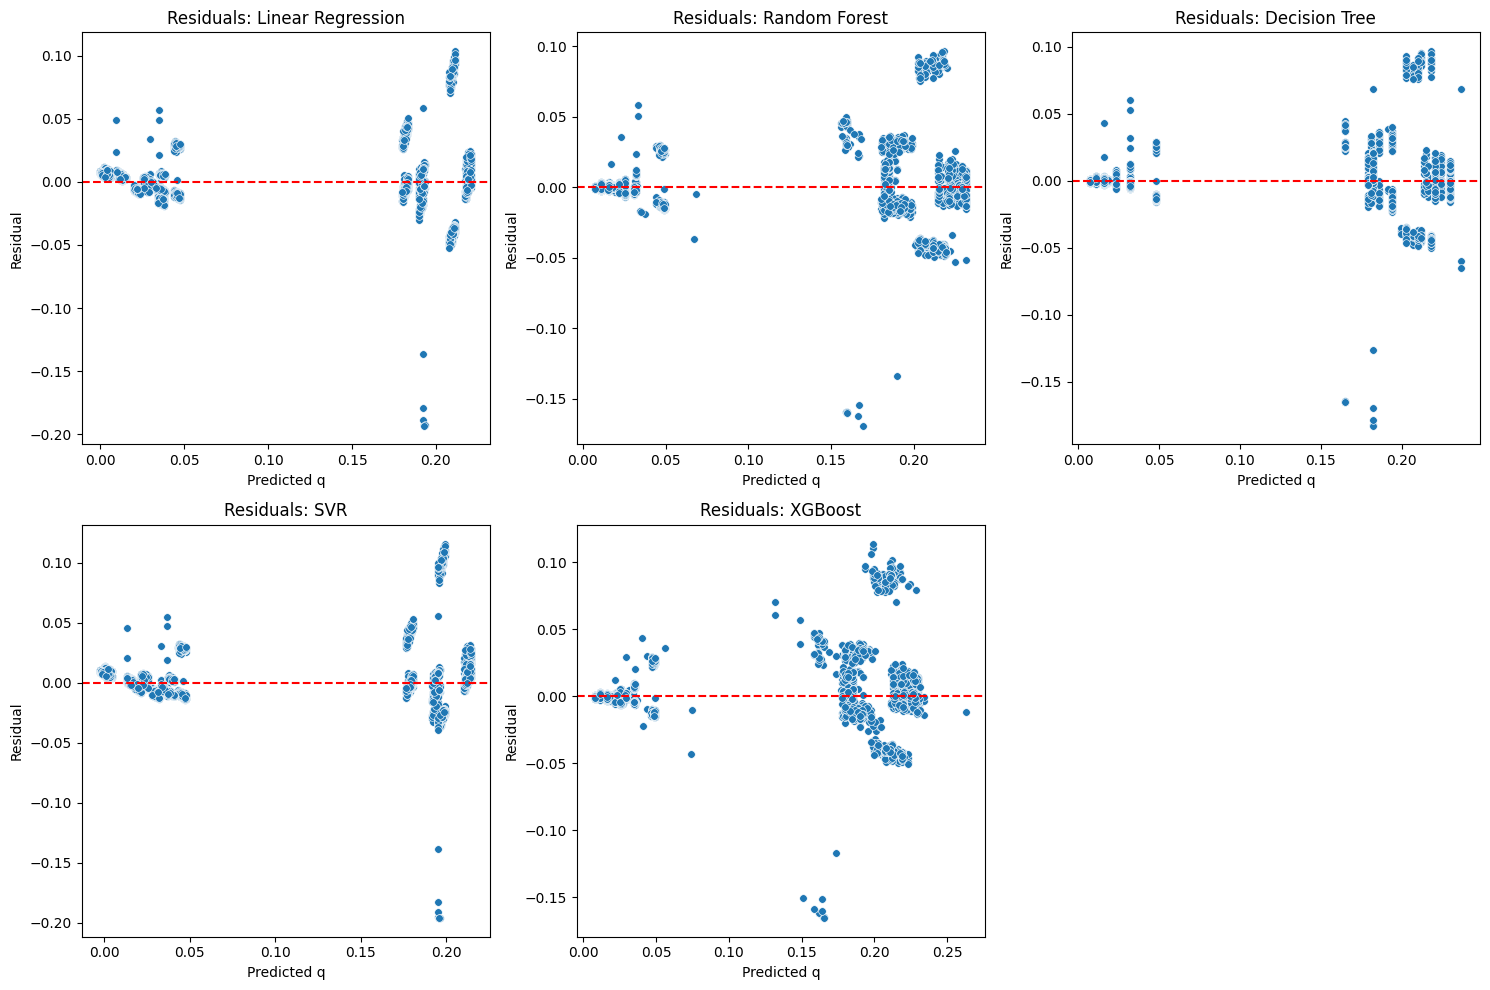

In [45]:
#plot the residual plots for all the models
#dictionary of all predicted value for all the models
model_preds = {
    'Linear Regression': y_pred_lr,
    'Random Forest': y_pred_rf,
    'Decision Tree': y_pred_dec,
    'SVR': y_pred_svr,
    'XGBoost': y_pred_xgb
}
#figure size
plt.figure(figsize=(15, 10))
#for loop over the dictionary
for i, (name, preds) in enumerate(model_preds.items(), 1):
    plt.subplot(2, 3, i) #create subplots
    residuals = y_test - preds #calculate residuals
    sns.scatterplot(x=preds, y=residuals, s=30) #use sns to plot the prediction against the residuals
    plt.axhline(0, color='red', linestyle='--') #add a horizontal line to show 0
    plt.title(f"Residuals: {name}") #title of the plot
    plt.xlabel("Predicted q") #label x axis
    plt.ylabel("Residual") #label y axis

plt.tight_layout()
plt.show()

## Postprocessing

               Model  R2_Score  Rank
0      Random Forest  0.941667   1.0
1      Decision Tree  0.941504   2.0
2            XGBoost  0.940995   3.0
3  Linear Regression  0.934984   4.0
4                SVR  0.931358   5.0


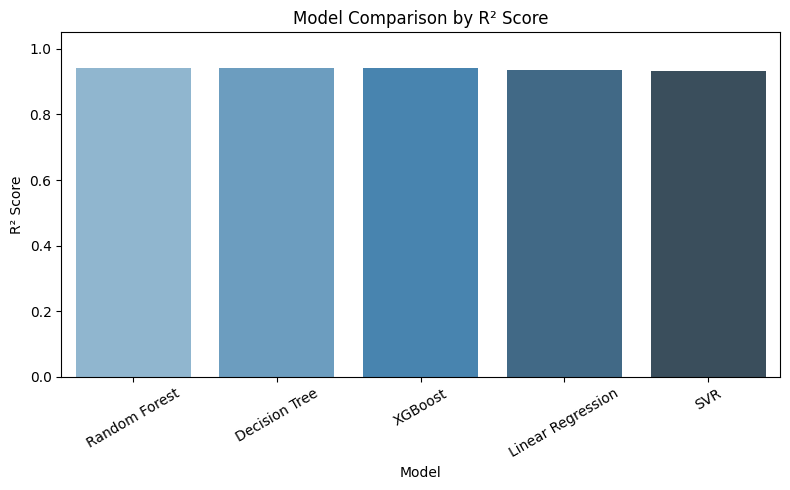

In [48]:
#ranking of the models
# Dictionary to store models and their predictions
model_results = {
    'Linear Regression': r2_score(y_test, y_pred_lr),
    'Random Forest': r2_score(y_test, y_pred_rf),
    'Decision Tree': r2_score(y_test, y_pred_dec),
    'SVR': r2_score(y_test, y_pred_svr),
    'XGBoost': r2_score(y_test, y_pred_xgb)
}

# Convert to DataFrame with two columns
model_scores_df = pd.DataFrame(list(model_results.items()), columns=['Model', 'R2_Score'])

# Rank the models (higher R^2 is better)
model_scores_df['Rank'] = model_scores_df['R2_Score'].rank(ascending=False)

# Sort for presentation
model_scores_df = model_scores_df.sort_values(by='R2_Score', ascending=False).reset_index(drop=True)
#print the scores
print(model_scores_df)

plt.figure(figsize=(8, 5))
#bar plot of the scores for the five models, x is the models and y is the score from the dataset  that was defined above
#the color is based on the model
sns.barplot(data=model_scores_df, x='Model', y='R2_Score', hue='Model', palette='Blues_d')
#title of the plot
plt.title('Model Comparison by R² Score')
plt.ylim(0, 1.05) #limit on the y axis
plt.ylabel('R² Score') #y label
plt.xticks(rotation=30) #add tickes to the x axis
plt.tight_layout()
plt.show()

In [52]:
#inverse design for the polymer system
# 1. Build a grid of valid combinations
dyn_vals = np.linspace(0.005, 0.15, 10) #range of dynamic crosslink from 0.5-15%
per_vals = np.linspace(0.005, 0.05, 10) #range of permamnent croslsink from 0.5-5%
temps = np.linspace(298, 373, 1) #temperature range
poly_options = ['254', '365'] #list of polymerization

# 2. Generate grid and calculate comonomer
#apply itertools to the design space
design_space = pd.DataFrame( #create dataframe
    itertools.product(dyn_vals, per_vals, temps, poly_options), #return Cartesian product to create new inputs for the model
    columns=['dyn_crosslinker', 'per_crosslinker', 'Temp (K)', 'Polymerization'] #define column
)
design_space['comonomer'] = 1.0 - (design_space['dyn_crosslinker'] + design_space['per_crosslinker']) #make the total to be 1
design_space = design_space[design_space['comonomer'] >= 0].reset_index(drop=True) #the comonomer should not be negative


# 3. Apply manual feature engineering for consistency with model
# This assumes percentages (not raw amounts)
total = design_space['dyn_crosslinker'] + design_space['per_crosslinker'] + design_space['comonomer'] #verify the total is not more than 1
design_space['dyn_crosslinker_pct'] = design_space['dyn_crosslinker'] / total #get the percentage of dynamic
design_space['per_crosslinker_pct'] = design_space['per_crosslinker'] / total #get the percentage of permamnent
design_space['comonomer_pct'] = design_space['comonomer'] / total #comonomer percentage
design_space['crosslink_ratio'] = design_space['dyn_crosslinker_pct'] / (design_space['per_crosslinker_pct'] + 1e-6) #the crosslink ratio

# 4. Drop unused original columns if needed (depends on your preprocessor)
#drop the columns that are not needed, similar to the above
columns_to_keep = ['dyn_crosslinker_pct', 'per_crosslinker_pct', 'comonomer_pct',
                   'crosslink_ratio', 'Temp (K)', 'Polymerization']
design_space_fe = design_space[columns_to_keep] #redesign the design space with the new column
design_space_fe['Polymerization'] = design_space_fe['Polymerization'].astype(str)

# 5. Transform using the same preprocessor from training
design_space_proc = preprocessor.transform(design_space_fe) #preprocess the dataset

# 6. Predict with your fitted decision tree model
design_space['Predicted_q'] = dec_model.predict(design_space_proc) #predict crosslink density

# 7. Filter or rank
target_q = 0.05 #pick target q
tolerance = 0.01 #tolerance
design_space['error'] = np.abs(design_space['Predicted_q'] - target_q) #calculated the erro from target and the predicted from the model
inverse_matches = design_space.sort_values(by='error').head(10) #show the top 10 sorted on the lowest error

# 8. Display results
print(inverse_matches[['dyn_crosslinker', 'per_crosslinker', 'comonomer',
                       'Polymerization', 'Predicted_q', 'error']]) #print the results from

     dyn_crosslinker  per_crosslinker  comonomer Polymerization  Predicted_q  \
102         0.085556             0.01   0.904444            254     0.048114   
122         0.101667             0.01   0.888333            254     0.048114   
142         0.117778             0.01   0.872222            254     0.048114   
2           0.005000             0.01   0.985000            254     0.031861   
62          0.053333             0.01   0.936667            254     0.031861   
82          0.069444             0.01   0.920556            254     0.031861   
42          0.037222             0.01   0.952778            254     0.031861   
22          0.021111             0.01   0.968889            254     0.031861   
83          0.069444             0.01   0.920556            365     0.023611   
63          0.053333             0.01   0.936667            365     0.023611   

        error  
102  0.001886  
122  0.001886  
142  0.001886  
2    0.018139  
62   0.018139  
82   0.018139  
42   0.

/tmp/ipykernel_768721/1139360357.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  design_space_fe['Polymerization'] = design_space_fe['Polymerization'].astype(str)
